In [74]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
from mnist import MNIST
from scipy.sparse import issparse

# kmeans
## init

Randomly pick 10 images as starting points.

In [60]:
def init(k, data, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, data.shape[1]))
    n_rows = data.shape[0]
    for rand in range(k):
        idx = np.random.choice(n_rows)
        if issparse(data):
            mu[rand] = np.asarray(data[idx].todense()).reshape(-1)
        else:
            mu[rand] = data[idx]
    return mu

## E step
Assign memberships from current mu's. <br>
Also evaluate loss

In [3]:
def e_step(mu, data):
    distances = np.matrix(euclidean_distances(X=data, Y=mu))
    loss = np.sum(distances.min(axis=1))
    return np.array(distances.argmin(1).T).ravel(), loss

In [78]:
def cosine_e_step(mu, data):
    sim = np.matrix(cosine_similarity(X=data, Y=mu))
    loss = np.sum(sim.max(axis=1))
    return np.array(sim.argmax(1).T).ravel(), loss

## M step
Calculate new mu's from current memberships

In [4]:
def m_step(pi, k, data):
    mu = np.empty((k, data.shape[1]))
    for cluster_id in range(k):
        cluster_data = data[np.where(pi == cluster_id)[0]]
        mu[cluster_id] = np.mean(cluster_data, axis=0)
    return mu

## external metrics

Helper function to get confusion matrix and cluster mappings for `k` and `pi`'s

In [5]:
def get_confusion_matrix(k, pi, labels, dims):
    conf_mat = np.empty(shape=(k, dims))
    for cluster_id in range(k):
        true_labels = labels[np.where(cluster_id == pi)]
        conf_mat[cluster_id] = np.bincount(true_labels, minlength=dims)
    return conf_mat

### Purity

In [6]:
def purity(confusion_matrix):
    Pj = confusion_matrix.max(axis=1)
    Mj = confusion_matrix.sum(axis=1)
    return sum(Pj)/sum(Mj)

### Gini

In [7]:
def gini(confusion_matrix):
    Mj = confusion_matrix.sum(axis=1, keepdims=True)
    gj = 1 - ((confusion_matrix/Mj)**2).sum(axis=1, keepdims=True)
    return (sum(gj*Mj)/sum(Mj))[0]

## k means helper

In [80]:
def kmeans(data, labels, k, init_func, pi_func, max_epochs, print_interval, seed):
    _loss, _purity, _gini = [], [], []
    
    # initial mu values
    _mu = init_func(k, data, seed)
    
    dims = len(np.unique(labels))
    
    p_loss = 0
    
    for _epoch in range(max_epochs):
        # e step
        _pi, loss = pi_func(_mu, data)
        
        # m step
        _mu = m_step(_pi, k, data)
        
        # evaluation
        conf_mat = get_confusion_matrix(k, _pi, labels, dims)
        p = purity(conf_mat)
        g = gini(conf_mat)
        
        # append to global
        _purity.append(p)
        _gini.append(g)
        _loss.append(loss)
        
        # print info
        if _epoch % print_interval == 0:
            print('\tEpoch:', _epoch, 'Loss:', loss, 
                  'Purity:', p, 'Gini Index:', g)
                
        if np.abs(loss - p_loss) < 0.001:
            print('\tConvergence at epoch {0}, Loss at {1}'.format(_epoch, loss))
            break
        p_loss = loss
        
        if _epoch == (max_epochs - 1):
            print('\tNo convergence after {0} epochs, try higher value. Loss at {1}'.format(max_epochs, loss))
            
    return _loss, _purity, _gini

## graph helpers

In [9]:
def graph_helper_loss(loss):
    plt.plot(range(len(loss)), np.log(loss))
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log_10)')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [10]:
def graph_helper_metrics(purity, gini):
    plt.plot(range(len(gini)), gini, 'r', label = 'Gini Index')
    plt.plot(range(len(purity)), purity, 'g', label = 'Purity')
    plt.xlabel('Epochs')
    plt.ylabel('Gini Index/Purity')
    plt.title('Gini Index/Purity vs Epochs')
    plt.legend()
    plt.show()

## All together

In [82]:
def do_kmeans(data, labels, ks, pi_func=e_step):
    seed = np.random.randint(data.shape[0])
    
    for k in ks:
        print('For k = {0}:'.format(k))
        t_loss, t_purity, t_gini = kmeans(data=data, labels=labels,
                                          k=k, init_func=init, 
                                          pi_func=pi_func,
                                          max_epochs=150, 
                                          print_interval=10, 
                                          seed=seed)
        
        print('\n\tFinal values: \n\t\tLoss: {0}'.format(t_loss[-1]))
        print('\t\tPurity: {0}'.format(t_purity[-1]))
        print('\t\tGini Index: {0}\n'.format(t_gini[-1]))
        
        graph_helper_loss(t_loss)
        graph_helper_metrics(t_purity, t_gini)

# MNIST

In [86]:
mnist_loader = MNIST("../data/mnist/")
mnist_loader.gz = True

In [87]:
images, labels = mnist_loader.load_training()

In [88]:
images = np.array(images)
labels = np.array(labels)

In [89]:
images.shape

(60000, 784)

For k = 10:
	Epoch: 0 Loss: 123308153.907 Purity: 0.369483333333 Gini Index: 0.762111484621
	Epoch: 10 Loss: 94633343.7671 Purity: 0.57515 Gini Index: 0.56830457561
	Epoch: 20 Loss: 94354200.9265 Purity: 0.59395 Gini Index: 0.536562836433
	Epoch: 30 Loss: 94309010.599 Purity: 0.5838 Gini Index: 0.541066117093
	Epoch: 40 Loss: 94268258.5109 Purity: 0.585233333333 Gini Index: 0.546441900491
	Epoch: 50 Loss: 94253827.7343 Purity: 0.583966666667 Gini Index: 0.548451916849
	Epoch: 60 Loss: 94244334.7151 Purity: 0.582166666667 Gini Index: 0.548172162156
	Epoch: 70 Loss: 94230042.2304 Purity: 0.583066666667 Gini Index: 0.547212161212
	Epoch: 80 Loss: 94216054.5557 Purity: 0.583766666667 Gini Index: 0.546269125651
	Epoch: 90 Loss: 94209056.2343 Purity: 0.5838 Gini Index: 0.54581197792
	Epoch: 100 Loss: 94205260.1214 Purity: 0.583833333333 Gini Index: 0.54537451628
	Epoch: 110 Loss: 94201463.1405 Purity: 0.583133333333 Gini Index: 0.545424231868
	Epoch: 120 Loss: 94200490.1089 Purity: 0.58305 G

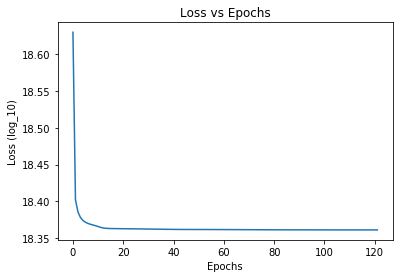

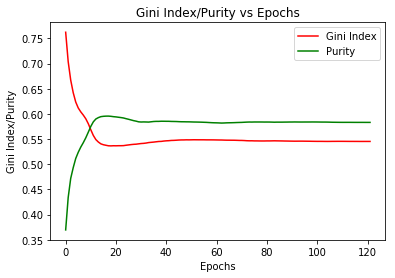

For k = 5:
	Epoch: 0 Loss: 130476676.353 Purity: 0.218583333333 Gini Index: 0.844973283987
	Epoch: 10 Loss: 99938890.6225 Purity: 0.412716666667 Gini Index: 0.7025980327
	Epoch: 20 Loss: 99603433.9073 Purity: 0.451783333333 Gini Index: 0.660065127371
	Epoch: 30 Loss: 99607684.447 Purity: 0.452316666667 Gini Index: 0.658528678034
	Convergence at epoch 38, Loss at 99607656.03836706

	Final values: 
		Loss: 99607656.03836706
		Purity: 0.45235
		Gini Index: 0.6584879639438661



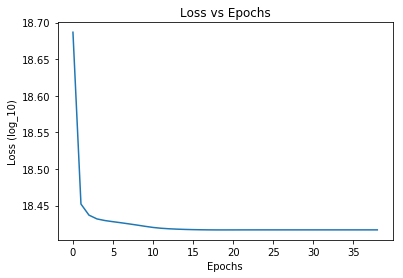

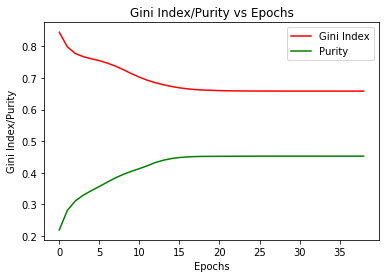

For k = 20:
	Epoch: 0 Loss: 116889492.998 Purity: 0.470283333333 Gini Index: 0.659341112007
	Epoch: 10 Loss: 89366474.9224 Purity: 0.687783333333 Gini Index: 0.409479960901
	Epoch: 20 Loss: 89299693.7065 Purity: 0.6893 Gini Index: 0.405609868925
	Epoch: 30 Loss: 89224181.8643 Purity: 0.699633333333 Gini Index: 0.398265049184
	Epoch: 40 Loss: 89090508.7524 Purity: 0.703866666667 Gini Index: 0.394069682258
	Epoch: 50 Loss: 89073463.002 Purity: 0.703633333333 Gini Index: 0.397745089254
	Epoch: 60 Loss: 89065944.8035 Purity: 0.704883333333 Gini Index: 0.399529703408
	Epoch: 70 Loss: 89061526.2061 Purity: 0.706516666667 Gini Index: 0.401029189798
	Epoch: 80 Loss: 89047203.7885 Purity: 0.710116666667 Gini Index: 0.40230004444
	Epoch: 90 Loss: 89033629.9591 Purity: 0.70955 Gini Index: 0.403065128835
	Epoch: 100 Loss: 89031123.8773 Purity: 0.709833333333 Gini Index: 0.402777928186
	Epoch: 110 Loss: 89030481.4118 Purity: 0.7102 Gini Index: 0.402517221272
	Convergence at epoch 115, Loss at 89030

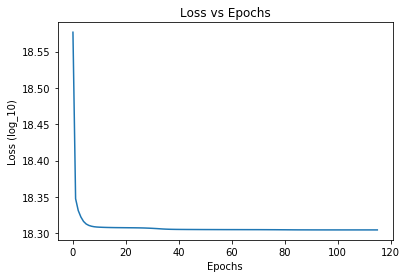

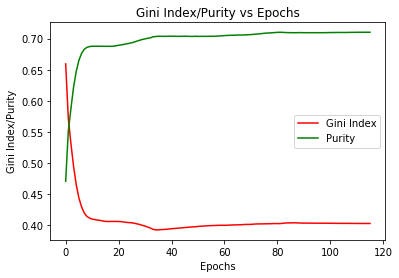

In [90]:
do_kmeans(images, labels, [10, 5, 20])

In [91]:
# cleanup
del images, labels

# FASHION

In [92]:
fashion = pd.read_csv('../data/fashion/fashion-mnist_train.csv')

In [93]:
f_labels = fashion['label']
del fashion['label']

In [94]:
f_labels = f_labels.values

In [95]:
fashion = fashion.values

In [96]:
fashion.shape, f_labels.shape

((60000, 784), (60000,))

For k = 10:
	Epoch: 0 Loss: 117513185.431 Purity: 0.421033333333 Gini Index: 0.68732860245
	Epoch: 10 Loss: 85311643.6362 Purity: 0.5088 Gini Index: 0.594642164657
	Epoch: 20 Loss: 84427480.5969 Purity: 0.51455 Gini Index: 0.580741781125
	Epoch: 30 Loss: 84435779.8146 Purity: 0.521616666667 Gini Index: 0.580520444783
	Epoch: 40 Loss: 84438926.1091 Purity: 0.526833333333 Gini Index: 0.580974865761
	Epoch: 50 Loss: 84371627.5218 Purity: 0.545533333333 Gini Index: 0.574489133452
	Epoch: 60 Loss: 84329591.2386 Purity: 0.55505 Gini Index: 0.566307568026
	Epoch: 70 Loss: 84325237.9665 Purity: 0.556566666667 Gini Index: 0.564699899038
	Epoch: 80 Loss: 84325656.1195 Purity: 0.556833333333 Gini Index: 0.56439215521
	Convergence at epoch 86, Loss at 84326037.25285926

	Final values: 
		Loss: 84326037.25285926
		Purity: 0.5568166666666666
		Gini Index: 0.5644352545662803



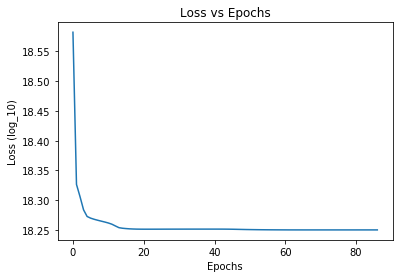

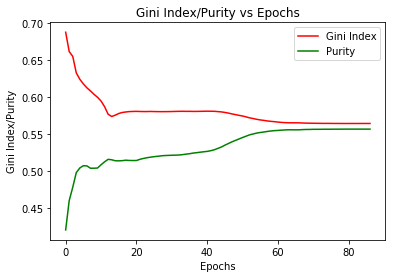

For k = 5:
	Epoch: 0 Loss: 140098376.293 Purity: 0.26925 Gini Index: 0.81402801623
	Epoch: 10 Loss: 93876362.221 Purity: 0.37995 Gini Index: 0.720236798541
	Epoch: 20 Loss: 93298787.4914 Purity: 0.372866666667 Gini Index: 0.712366082344
	Epoch: 30 Loss: 93309457.4763 Purity: 0.374066666667 Gini Index: 0.7114427402
	Epoch: 40 Loss: 93308404.935 Purity: 0.37605 Gini Index: 0.71082411039
	Epoch: 50 Loss: 93306240.7261 Purity: 0.377183333333 Gini Index: 0.71062150525
	Epoch: 60 Loss: 93300952.7838 Purity: 0.378833333333 Gini Index: 0.709388976851
	Epoch: 70 Loss: 93295094.8637 Purity: 0.3803 Gini Index: 0.707874095546
	Epoch: 80 Loss: 93292217.1948 Purity: 0.38125 Gini Index: 0.706970544787
	Epoch: 90 Loss: 93291274.804 Purity: 0.38165 Gini Index: 0.706602360571
	Convergence at epoch 98, Loss at 93290846.02294229

	Final values: 
		Loss: 93290846.02294229
		Purity: 0.3817333333333333
		Gini Index: 0.7065026144587243



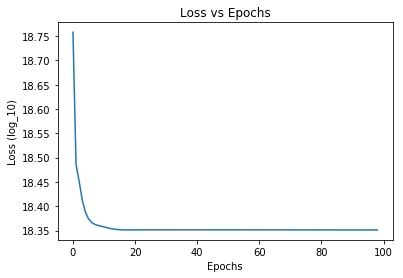

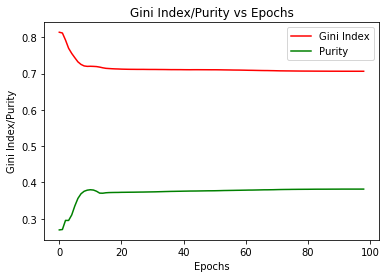

For k = 20:
	Epoch: 0 Loss: 104049697.051 Purity: 0.529133333333 Gini Index: 0.571710293121
	Epoch: 10 Loss: 77244177.7581 Purity: 0.651866666667 Gini Index: 0.445943662332
	Epoch: 20 Loss: 77086280.3845 Purity: 0.651283333333 Gini Index: 0.446825518167
	Epoch: 30 Loss: 77075564.4384 Purity: 0.651816666667 Gini Index: 0.44677806802
	Epoch: 40 Loss: 77073022.9561 Purity: 0.6526 Gini Index: 0.446676094481
	Epoch: 50 Loss: 77069291.4797 Purity: 0.6524 Gini Index: 0.446566008504
	Epoch: 60 Loss: 77066713.969 Purity: 0.652683333333 Gini Index: 0.44597960549
	Epoch: 70 Loss: 77065980.8556 Purity: 0.653166666667 Gini Index: 0.445765891886
	Epoch: 80 Loss: 77065907.0926 Purity: 0.653216666667 Gini Index: 0.445672624284
	Convergence at epoch 85, Loss at 77065874.18528335

	Final values: 
		Loss: 77065874.18528335
		Purity: 0.6532833333333333
		Gini Index: 0.4456318656858231



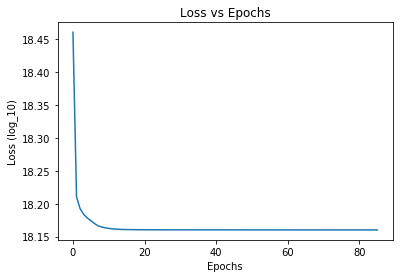

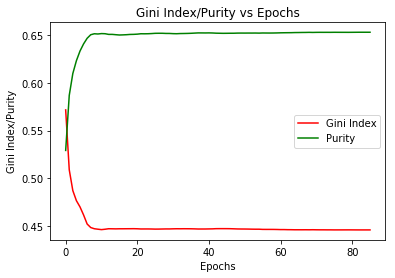

In [97]:
do_kmeans(data=fashion, labels=f_labels, ks=[10, 5, 20])

In [98]:
# cleanup
del fashion, f_labels

# 20 News Groups

In [99]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
news_train = fetch_20newsgroups(
    data_home='../data/20newsgroups/', 
    subset='train')

In [101]:
vectorizer = TfidfVectorizer(stop_words='english')

In [102]:
feature_matrix = vectorizer.fit_transform(news_train.data)

For k = 20:
	Epoch: 0 Loss: 561.752865278 Purity: 0.265069824996 Gini Index: 0.868955288632
	Epoch: 10 Loss: 1999.58064647 Purity: 0.501237404985 Gini Index: 0.636424914823
	Epoch: 20 Loss: 2006.97446895 Purity: 0.505921866714 Gini Index: 0.629355486195
	Epoch: 30 Loss: 2009.42209507 Purity: 0.514141771257 Gini Index: 0.621284668692
	Epoch: 40 Loss: 2010.52204196 Purity: 0.514583701609 Gini Index: 0.619597902918
	Convergence at epoch 46, Loss at 2010.6947056202584

	Final values: 
		Loss: 2010.6947056202584
		Purity: 0.5143185433975606
		Gini Index: 0.6199461319549912



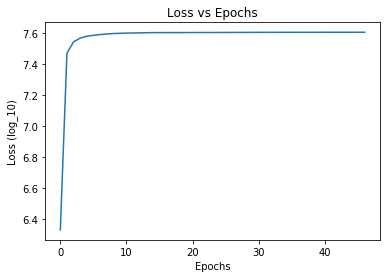

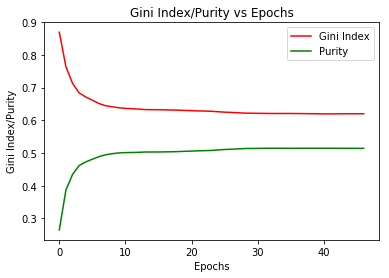

For k = 5:
	Epoch: 0 Loss: 283.779685851 Purity: 0.133904896588 Gini Index: 0.93118853837
	Epoch: 10 Loss: 1541.7641467 Purity: 0.203376347888 Gini Index: 0.858393154792
	Convergence at epoch 19, Loss at 1542.7425069501228

	Final values: 
		Loss: 1542.7425069501228
		Purity: 0.20390666430970478
		Gini Index: 0.8574151520041963



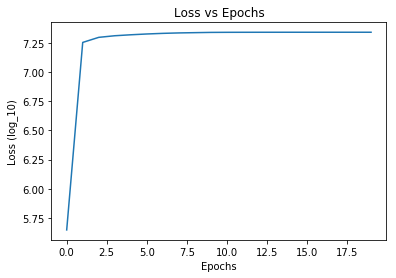

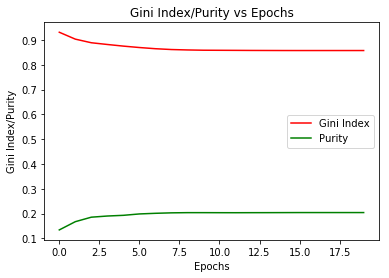

For k = 10:
	Epoch: 0 Loss: 405.35186314 Purity: 0.1741205586 Gini Index: 0.916412209578
	Epoch: 10 Loss: 1710.27180479 Purity: 0.370602793 Gini Index: 0.742699485183
	Epoch: 20 Loss: 1712.03502472 Purity: 0.369365388015 Gini Index: 0.743443083931
	Convergence at epoch 22, Loss at 1712.0390541298166

	Final values: 
		Loss: 1712.0390541298166
		Purity: 0.36936538801484886
		Gini Index: 0.7434430839314097



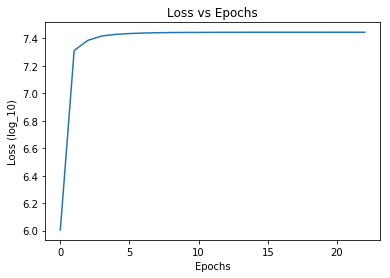

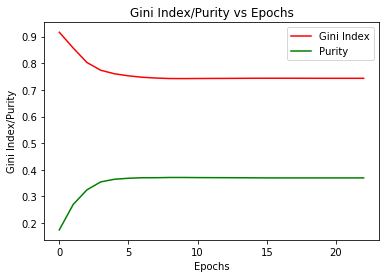

In [109]:
do_kmeans(data=feature_matrix, labels=news_train.target, ks=[20, 5, 10], pi_func=cosine_e_step)

In [122]:
del feature_matrix, news_train